# Time series analysis

Time series is a sequence of observations recorded at regular time intervals. Depending on the frequency of observations, a time series may typically be hourly, daily, weekly, monthly, quarterly and annual. Sometimes, you might have seconds and minute-wise time series as well, like, number of clicks and user visits every minute etc. Why even analyze a time series? Because it is the preparatory step before you develop a forecast of the series. Besides, time series forecasting has enormous commercial significance because stuff that is important to a business like demand and sales, number of visitors to a website, stock price etc are essentially time series data. So what does analyzing a time series involve? Time series analysis involves understanding various aspects about the inherent nature of the series so that you are better informed to create meaningful and accurate forecasts.

In our data timestamps are stored as strings, and we first need to convert them to datetime to be able to work with them

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('../data/trafikkregistreringspunkt_1_-_uke_42_og_43_2020.csv')

In [3]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'])

We can now ask Pandas for certain timestamp values based on the timestamp:

In [4]:
data['event_timestamp'].dt.hour

0         23
1         23
2         23
3         23
4         23
          ..
299772     0
299773     0
299774     0
299775     0
299776     0
Name: event_timestamp, Length: 299777, dtype: int64

In [5]:
data['event_timestamp'].dt.day

0         25
1         25
2         25
3         25
4         25
          ..
299772    12
299773    12
299774    12
299775    12
299776    12
Name: event_timestamp, Length: 299777, dtype: int64

In [6]:
data['event_timestamp'].dt.weekday

0         6
1         6
2         6
3         6
4         6
         ..
299772    0
299773    0
299774    0
299775    0
299776    0
Name: event_timestamp, Length: 299777, dtype: int64

In [7]:
data['event_timestamp'].dt.isocalendar().week

0         43
1         43
2         43
3         43
4         43
          ..
299772    42
299773    42
299774    42
299775    42
299776    42
Name: week, Length: 299777, dtype: UInt32

In [8]:
data['event_timestamp'].dt.month

0         10
1         10
2         10
3         10
4         10
          ..
299772    10
299773    10
299774    10
299775    10
299776    10
Name: event_timestamp, Length: 299777, dtype: int64

In [9]:
data['event_timestamp'].dt.year

0         2020
1         2020
2         2020
3         2020
4         2020
          ... 
299772    2020
299773    2020
299774    2020
299775    2020
299776    2020
Name: event_timestamp, Length: 299777, dtype: int64

Based on these value groups we can create basic descriptive statistics

In [10]:
data['event_timestamp'].dt.hour.describe()

count    299777.000000
mean         13.560760
std           4.606718
min           0.000000
25%          10.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: event_timestamp, dtype: float64

And we can plot them

In [11]:
import seaborn as sns

<AxesSubplot: xlabel='event_timestamp', ylabel='speed'>

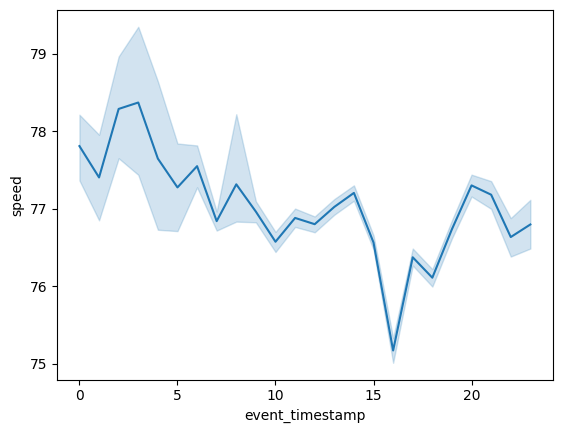

In [12]:
sns.lineplot(x=data['event_timestamp'].dt.hour, y=data['speed'])

<AxesSubplot: xlabel='event_timestamp', ylabel='speed'>

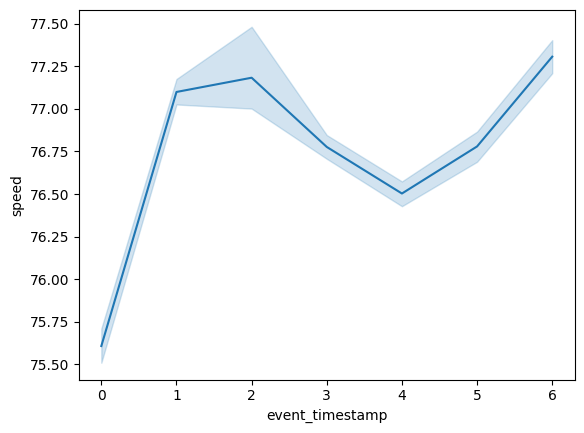

In [13]:
sns.lineplot(x=data['event_timestamp'].dt.dayofweek, y=data['speed'])

<AxesSubplot: xlabel='event_timestamp', ylabel='speed'>

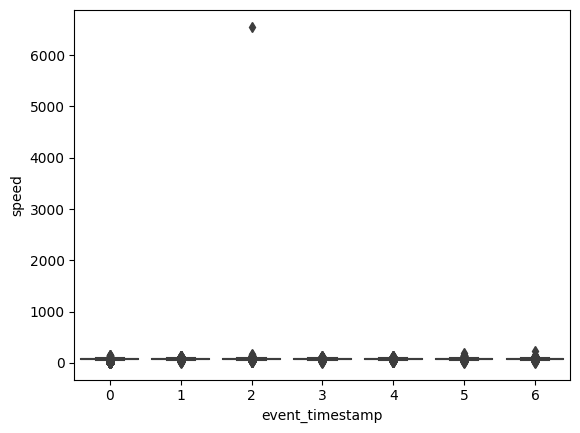

In [14]:
sns.boxplot(x=data['event_timestamp'].dt.dayofweek, y=data['speed'])

We have a huge and unrealistic outlier here that we need to remove

In [16]:
data = data.drop(data['speed'].idxmax())

<AxesSubplot: xlabel='event_timestamp', ylabel='speed'>

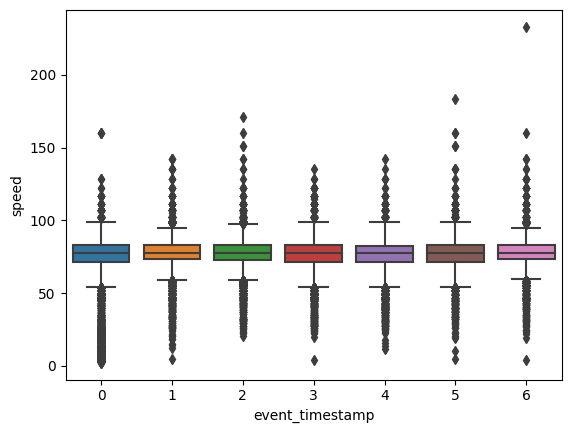

In [17]:
sns.boxplot(x=data['event_timestamp'].dt.dayofweek, y=data['speed'])

Often we are interested in patterns in some variable over time series. We can get a first impression by plotting the variable of interest over time

<AxesSubplot: xlabel='event_timestamp', ylabel='speed'>

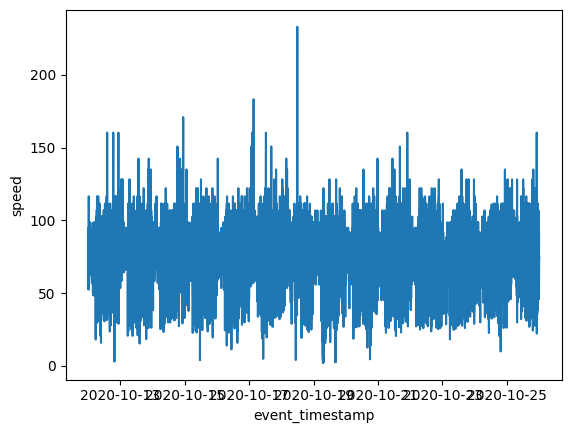

In [18]:
sns.lineplot(data=data, x='event_timestamp', y='speed')

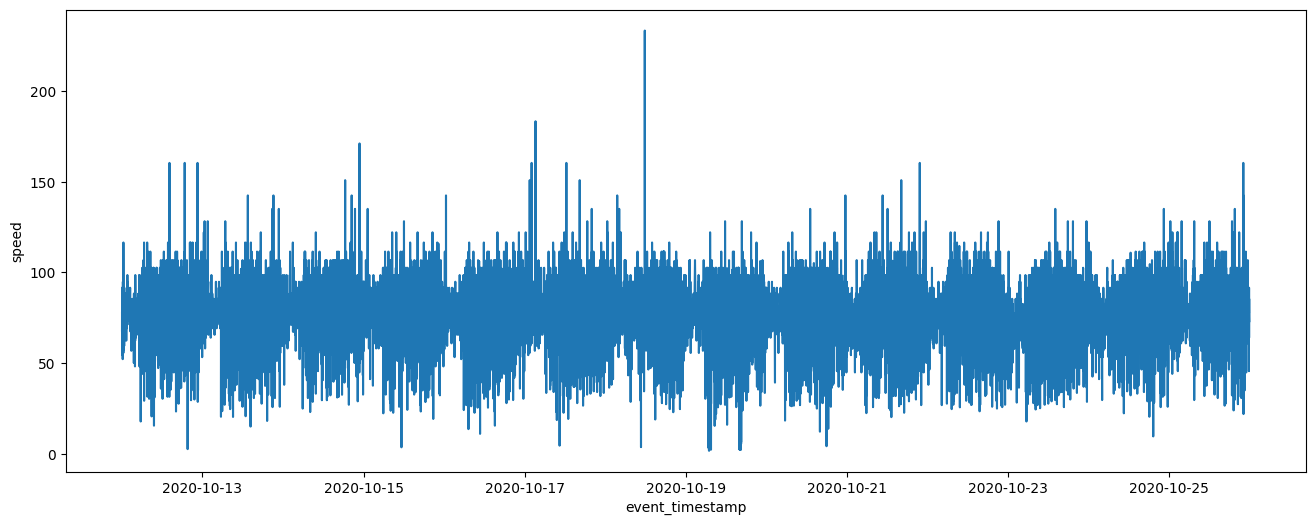

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,6))
ax = sns.lineplot(data=data, x='event_timestamp', y='speed')

There appears to be some repetitiveness in the data. 

Any time series may be split into the following components: Base Level + Trend + Seasonality + Error A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true. So, a time series may be imagined as a combination of the trend, seasonality and the error terms.

Another aspect to consider is the cyclic behaviour. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect. So, How to diffentiate between a ‘cyclic’ vs ‘seasonal’ pattern? If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

### Additive and multiplicative time series

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components: Additive time series: Value = Base Level + Trend + Seasonality + Error Multiplicative Time Series: Value = Base Level x Trend x Seasonality x Error

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
data = data.set_index('event_timestamp')

In [22]:
data = data.sort_index()

Our data must not contain missing values. Because we are dealing with recordings of vehicles past a registration point it does not make sense to impute the values. We will drop those rows.

In [23]:
speed = data['speed'].copy()

In [24]:
speed = speed.dropna()

For seasonal decomposition our data needs to be evenly distributed, for example by hour.

In [25]:
speed = speed.resample('H').mean()

In [26]:
result_mul = seasonal_decompose(speed, model='multiplicative', extrapolate_trend='freq')

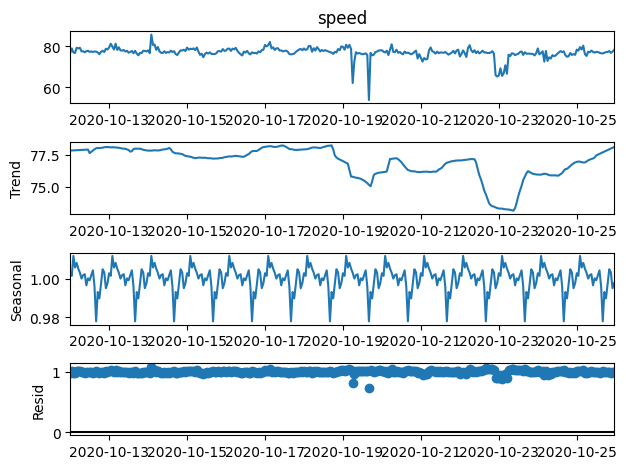

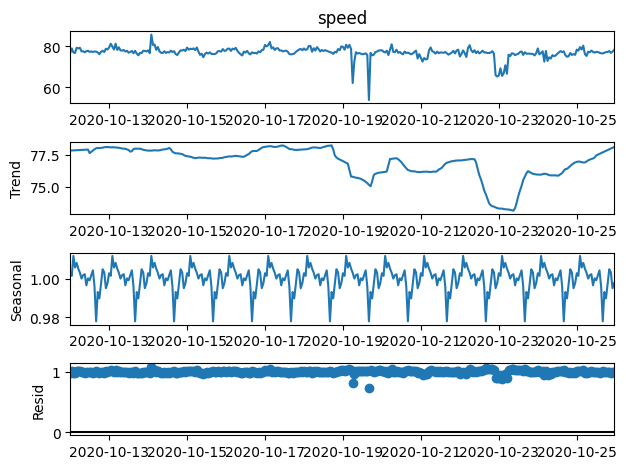

In [27]:
result_mul.plot()

<AxesSubplot: xlabel='event_timestamp'>

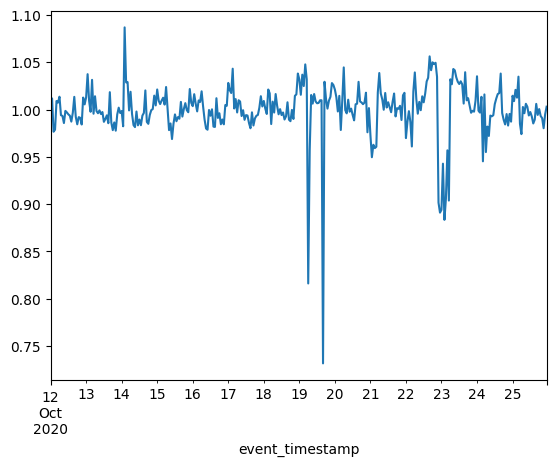

In [28]:
result_mul.resid.plot()

In [29]:
result_add = seasonal_decompose(speed, model='additive', extrapolate_trend='freq')

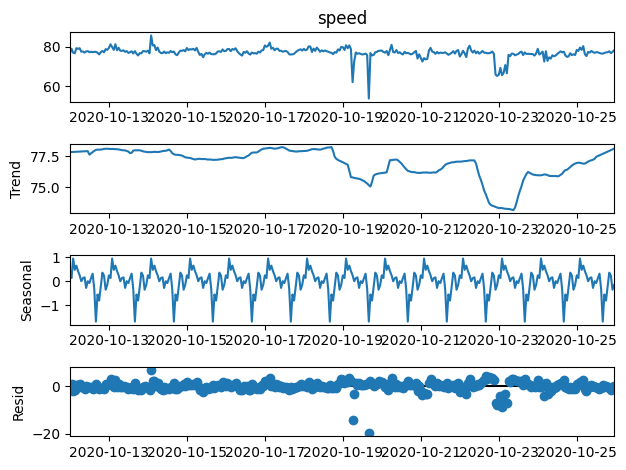

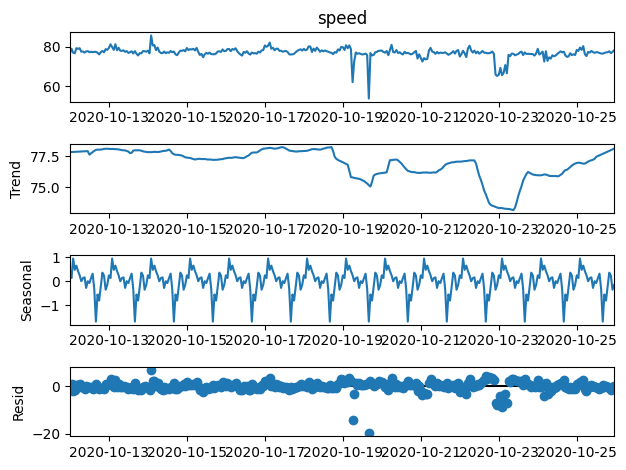

In [30]:
result_add.plot()

<AxesSubplot: xlabel='event_timestamp'>

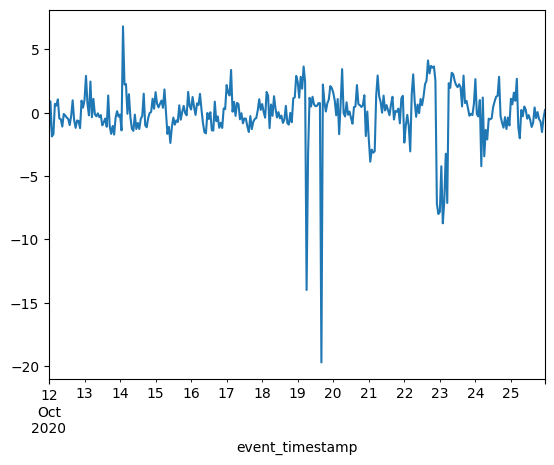

In [31]:
result_add.resid.plot()

What we are looking for is uncorrelated random residuals with a zero mean, i.e. no seasonal components left. Here, we should use the additive model.

### Stationary and non-stationary time series

Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time. A stationary time series id devoid of seasonal effects as well.

Why is this relevant? It is possible to make nearly any time series stationary by applying a suitable transformation. Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.

### Testing for stationarity

The stationarity of a series can be established by using statistical tests called ‘Unit Root Tests’. There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root. There are multiple implementations of Unit Root tests like:

**Augmented Dickey Fuller test (ADF Test)**
- Null hypothesis: The series has a unit root (series is not stationary)
- If the null hypothesis cannot be rejected (p > 0.05) the time series may be non-stationary.

In [34]:
from statsmodels.tsa.stattools import adfuller, kpss

In [35]:
result = adfuller(speed.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.356232929613755
p-value: 0.00035449218261026353
Critial Values:
   1%, -3.450632157720528
Critial Values:
   5%, -2.870474482366864
Critial Values:
   10%, -2.5715301325443787


**Kwiatkowski-Phillips-Schmidt-Shin (KPSS test)**
- Null hypothesis: The process is trend stationary.

In [36]:
result = kpss(speed.values, regression='ct')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.065765
p-value: 0.100000
Critial Values:
   10%, 0.119
Critial Values:
   5%, 0.146
Critial Values:
   2.5%, 0.176
Critial Values:
   1%, 0.216


/home/alexandra/miniconda3/envs/data-science/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


We can first carry out the ADF test. If we cannot reject the null hypothesis, the KPSS test can tell us whether the series might be trend stationary instead. In our case we could already reject the null hypothesis of the ADF test, so our series is stationary.

**Autocorrelation plot**

An autocorrelation plot is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. The horizontal axis of an autocorrelation plot shows the size of the lag between the elements of the time series. For example, the autocorrelation with lag 2 is the correlation between the time series elements and the corresponding elements that were observed two time periods earlier. On the graph, there is a vertical line (a "spike") corresponding to each lag. The height of each spike shows the value of the autocorrelation function for the lag. The autocorrelation with lag zero always equals 1, because this represents the autocorrelation between each term and itself. Price and price with lag zero are the same variable. Each spike that rises above or falls below the dashed lines is considered to be statistically significant. This means the spike has a value that is significantly different from zero. If a spike is significantly different from zero, that is evidence of autocorrelation. A spike that's close to zero is evidence against autocorrelation.

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

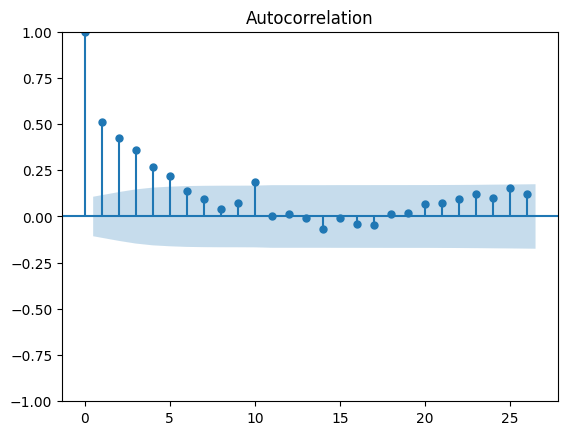

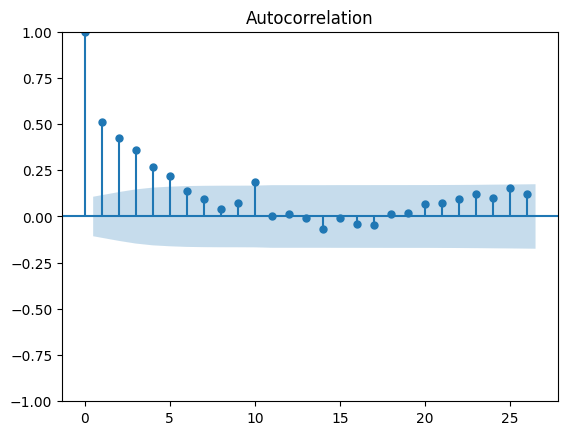

In [38]:
plot_acf(speed)

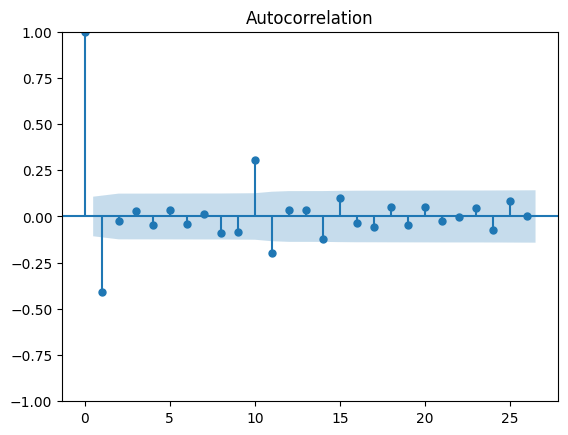

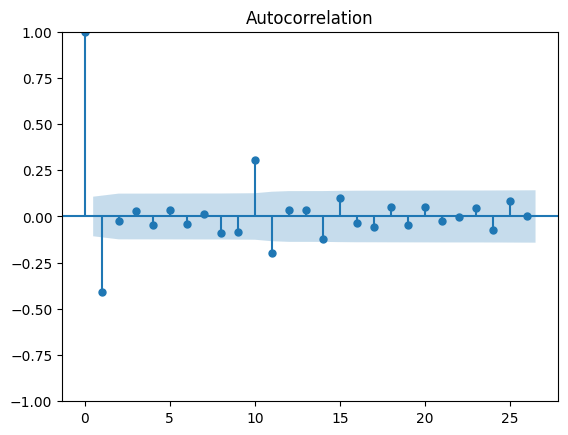

In [39]:
plot_acf(speed.diff().dropna())

The autocorrelation plot suggests that differentiating once could be a good idea.

### Making a time series stationary

You can make series stationary by:

- Differencing the Series (once or more often)
- Take the log of the series
- Take the nth root of the series
- Combination of the above

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary. So what is differencing? If Y_t is the value at time ‘t’, then the first difference of Y = Yt – Yt-1. In simpler terms, differencing the series is nothing but subtracting the next value by the current value. If the first difference doesn’t make a series stationary, you can go for the second differencing.

<AxesSubplot: xlabel='event_timestamp'>

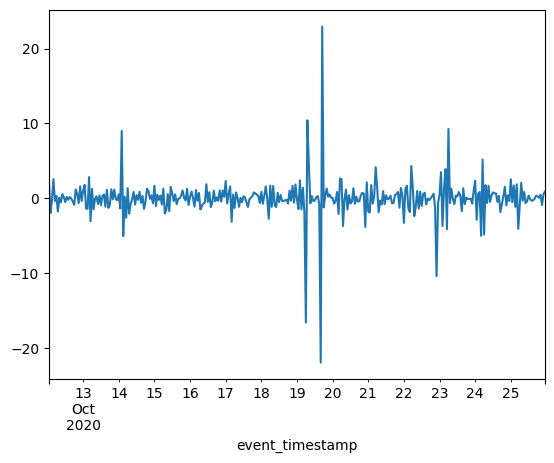

In [45]:
diff = speed.diff().dropna()
diff.plot()

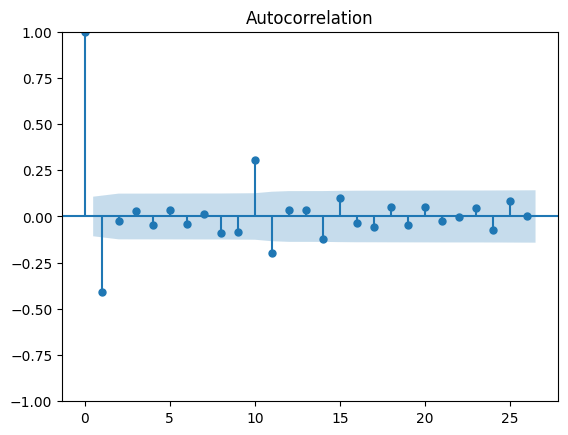

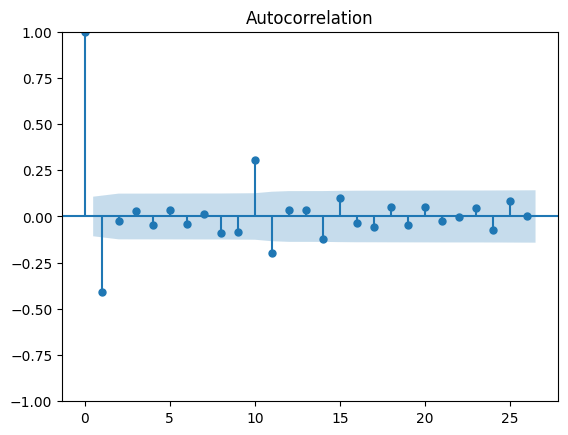

In [46]:
plot_acf(diff)

<AxesSubplot: xlabel='event_timestamp'>

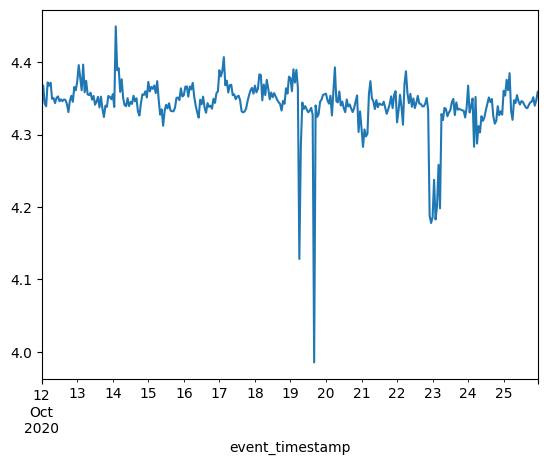

In [48]:
import numpy as np
speed_log = np.log(speed)
speed_log.plot()

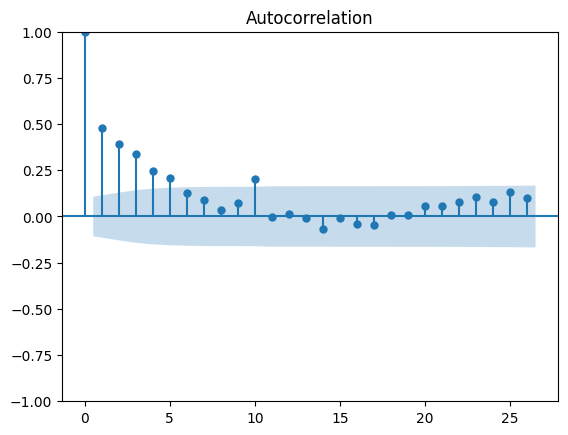

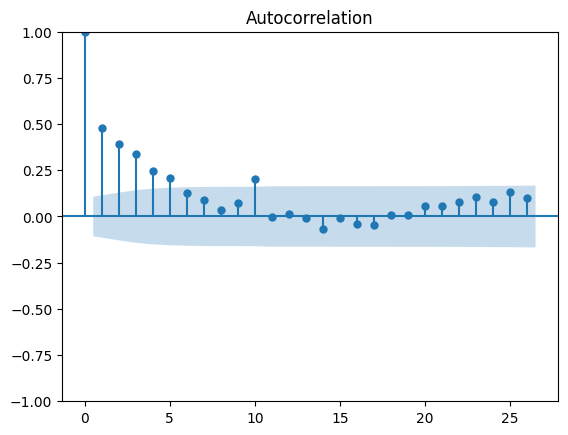

In [49]:
plot_acf(speed_log)

### Detrending a time series

Detrending a time series is to remove the trend component from a time series. There are multiple ways of doing this:

1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.
2. Subtract the trend component obtained from time series decomposition we saw earlier.
3. Subtract the mean
4. Apply a filter like Baxter-King filter (`statsmodels.tsa.filters.bkfilter`) or the Hodrick-Prescott Filter (`statsmodels.tsa.filters.hpfilter`) to remove the moving average trend lines or the cyclical components.

Method 1:

In [50]:
from scipy import signal

In [51]:
detrended = signal.detrend(speed.values)

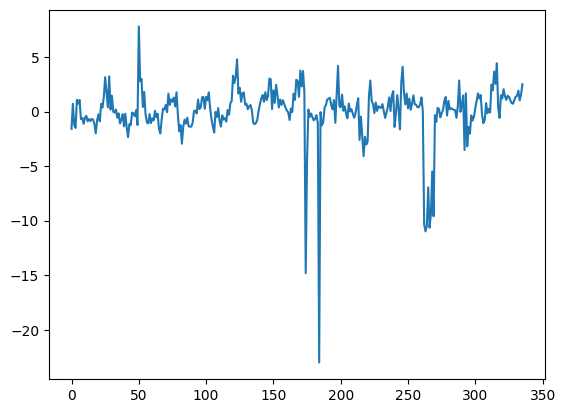

In [52]:
plt.plot(detrended)

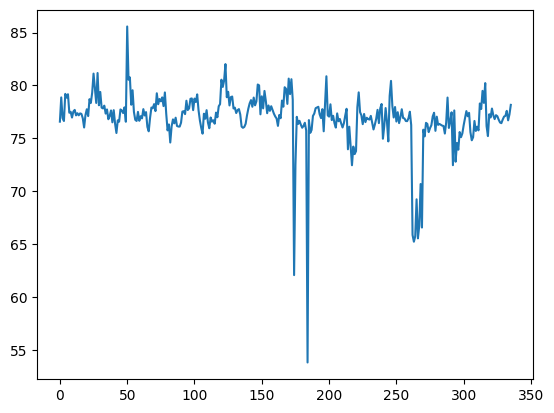

In [53]:
plt.plot(speed.values)

Method 2:

In [60]:
# subtraction for additive ts, division for multiplicative ts
detrended = speed.values - result_add.trend

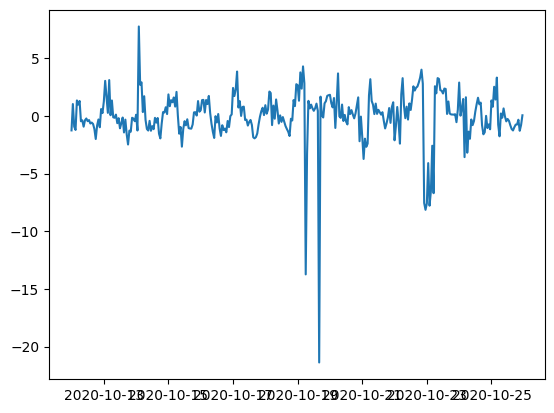

In [59]:
plt.plot(detrended)

Method 3:

In [56]:
detrended = signal.detrend(speed.values, type='constant')

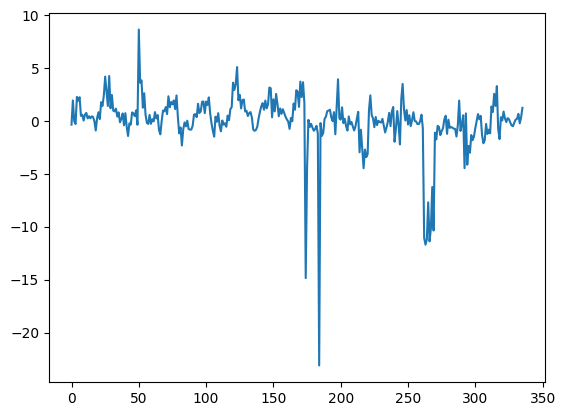

In [57]:
plt.plot(detrended)

Detrending centres the mean around 0.

### Deseasonalising a time series

Again, there are multiple approaches to deseasonalize a time series as well. Below are a few:

1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.
2. Seasonal difference the series (subtract the value of previous season from the current value)
3. Divide the series by the seasonal index obtained from STL decomposition

If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. You can later restore to the original scale by taking an exponential.

In [61]:
# subtraction for additive ts, division for multiplicative ts
deseasonalized = speed.values - result_add.seasonal

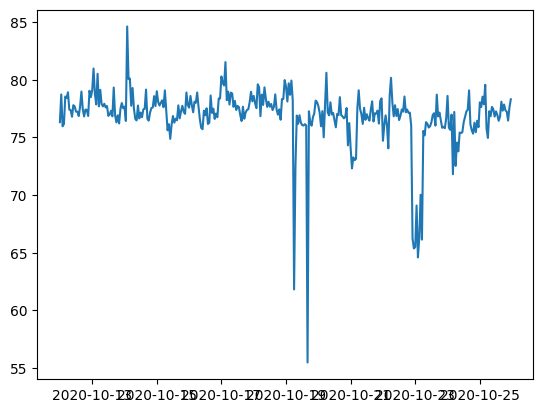

In [62]:
plt.plot(deseasonalized)

### Smoothing a time series

Smoothing of a time series may be useful in:

- Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series.
- The smoothed version of series can be used as a feature to explain the original series itself.
- Visualize the underlying trend better

So how to smoothen a series? Let’s discuss the following methods:

- Take a moving average
- Do a LOWESS smoothing (Locally Weighted Regression)

Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect. LOWESS, short for ‘LOcalized Weighted regrESSion’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

In [63]:
movav = speed.rolling(3, center=True, closed='both').mean()

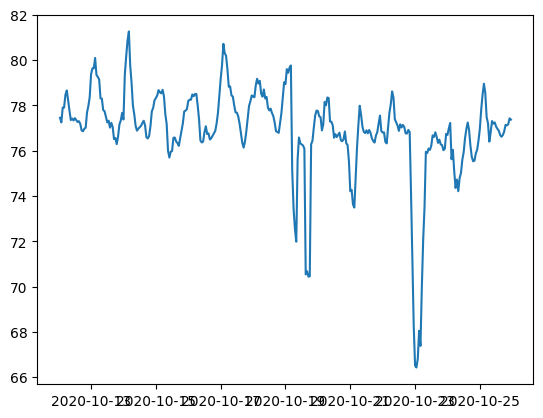

In [64]:
plt.plot(movav)

In [65]:
movav2 = speed.rolling(24, center=True, closed='both').mean()

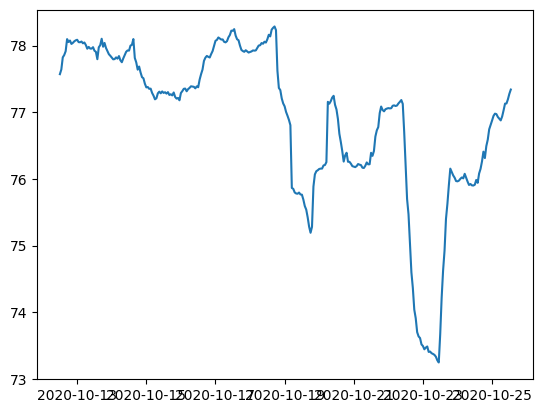

In [66]:
plt.plot(movav2)

In [67]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

In [71]:
lowess_5_array = lowess(speed, np.arange(len(speed)), frac=0.05)
lowess_5_col = lowess_5_array[:, 1]
lowess_5 = pd.DataFrame(lowess_5_col, index=speed.index, columns=['speed'])

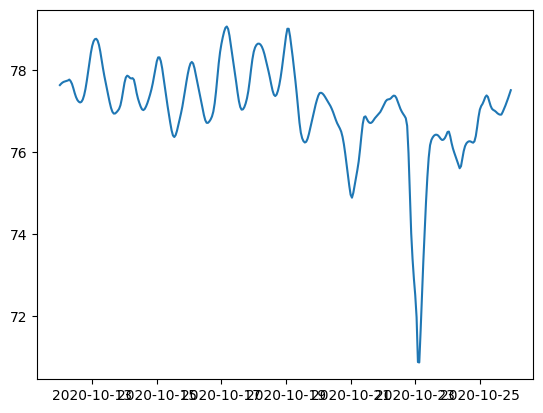

In [72]:
plt.plot(lowess_5)

In [73]:
lowess_2_array = lowess(speed, np.arange(len(speed)), frac=0.02)
lowess_2_col = lowess_2_array[:, 1]
lowess_2 = pd.DataFrame(lowess_2_col, index=speed.index, columns=['speed'])

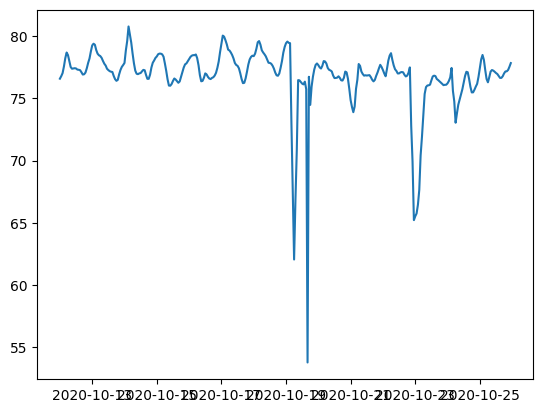

In [74]:
plt.plot(lowess_2)

### Forecasting a time series using (S)ARIMA

ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

- p is the order of the AR term
- q is the order of the MA term
- d is the number of differencing required to make the time series stationary

If a time series has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

The term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models work best when the predictors are not correlated and are independent of each other. The most common approach to make a time-series stationary is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed. The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

If you have the computing power, you can test through a number of permutations of (p, q, d), but it is generally a good idea to attempt to determine sensible values.

We previously determined using and ADF test that in our case d=1, maybe even d=2.

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot, which can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

In [83]:
import statsmodels.api as sm

In [87]:
res = sm.tsa.arma_order_select_ic(speed.diff(), ic=["aic", "bic"], trend="n")

/home/alexandra/miniconda3/envs/data-science/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [88]:
res.aic_min_order

(1, 2)

In [89]:
res.bic_min_order

(1, 2)

In [90]:
p, q = res.bic_min_order

Now we can build the ARIMA model.

In [143]:
from statsmodels.tsa.arima.model import ARIMA

# 1, 2, 1 ARIMA Model
model = ARIMA(speed, order=(p, 1, q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  speed   No. Observations:                  336
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -742.106
Date:                Wed, 05 Oct 2022   AIC                           1492.212
Time:                        10:20:35   BIC                           1507.469
Sample:                    10-12-2020   HQIC                          1498.295
                         - 10-25-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7859      0.071     11.129      0.000       0.647       0.924
ma.L1         -1.3971      0.077    -18.054      0.000      -1.549      -1.245
ma.L2          0.4049      0.070      5.826      0.0

Plotting residuals to ensure that there are no patterns

<AxesSubplot: title={'center': 'Residuals'}, xlabel='event_timestamp'>

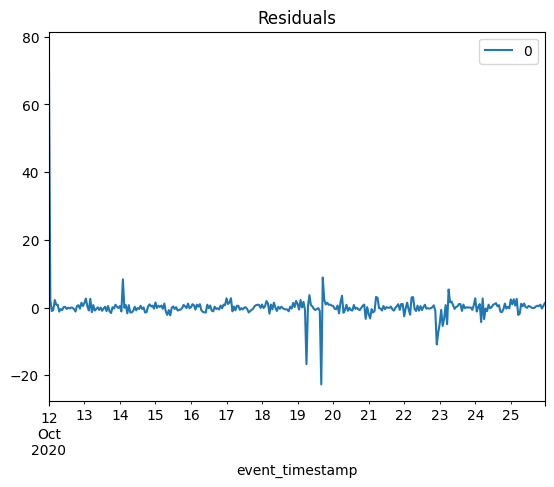

In [144]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")

The residuals look good. Let’s plot the actuals against the fitted values using plot_predict().

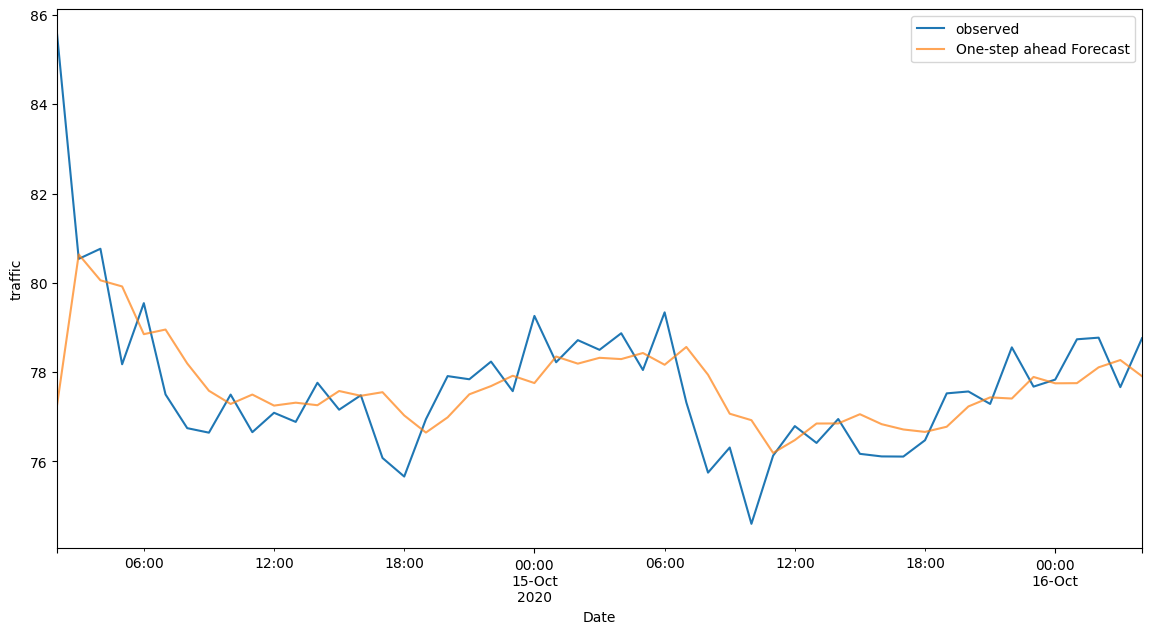

In [145]:
y = speed
pred = model_fit.get_prediction(start=y.index[50], end=y.index[100], dynamic=False)
pred_ci = pred.conf_int()
ax = y.iloc[50:101].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('traffic')
plt.legend()

### Accuracy metrics for time series forecasts

The commonly used accuracy metrics to judge forecasts are:

- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

Scikit-learn includes methods to calculate these metrics. Note that these measures only make sense in the context of comparing two predictions on the same data with one another. That is, a prediction with a RMSE of 20 is better than a prediction with a RMSE of 25, but the values don't indicate how good the better prediction is.

In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [147]:
mean_squared_error(speed.iloc[50:101], pred.predicted_mean)  # MSE

2.1299136097103286

In [148]:
mean_squared_error(speed.iloc[50:101], pred.predicted_mean, squared=False)           # RMSE

1.4594223548069725

In [149]:
mean_absolute_error(speed.iloc[50:101], pred.predicted_mean) # MAE

0.8501347589789406

### Adding seasonality: SARIMA

Our data is presented in hours, and we expect to see seasonality every 24 hours, so we set the parameter for seasonality s=24

<AxesSubplot: xlabel='event_timestamp'>

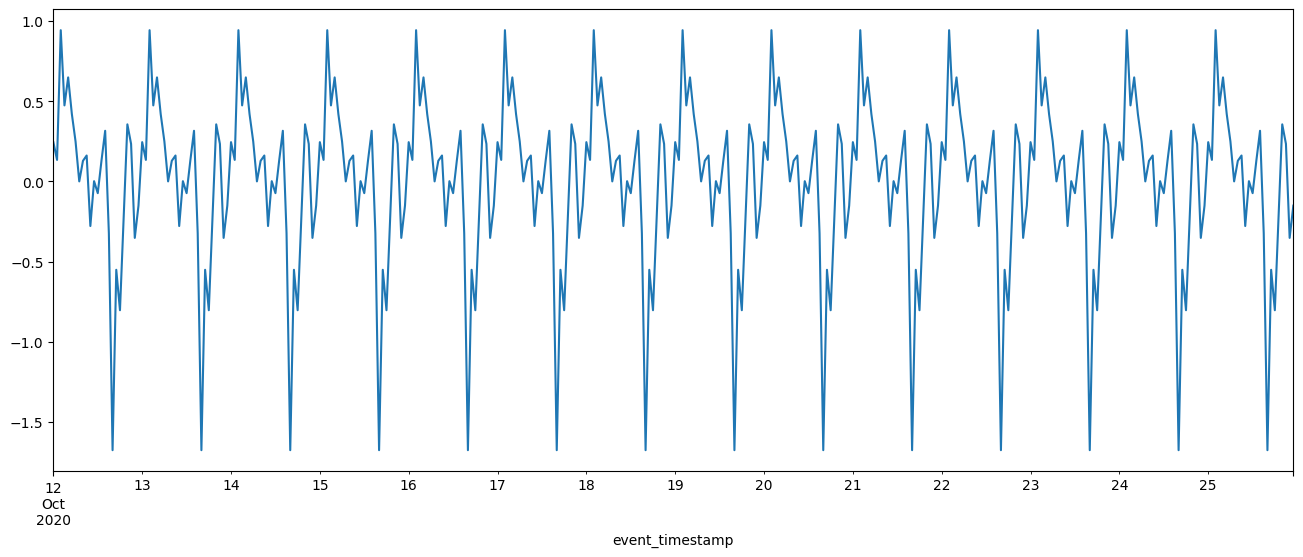

In [153]:
fig = plt.figure(figsize=(16,6))
result_add.seasonal.plot()

In [154]:
# SARIMA Model
model = ARIMA(speed, seasonal_order=(p, 1, q, 24))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:                       speed   No. Observations:                  336
Model:             ARIMA(1, 1, [1, 2], 24)   Log Likelihood                -778.350
Date:                     Wed, 05 Oct 2022   AIC                           1564.700
Time:                             10:22:41   BIC                           1579.672
Sample:                         10-12-2020   HQIC                          1570.684
                              - 10-25-2020                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.5862      2.409     -0.243      0.808      -5.308       4.135
ma.S.L24      -0.2062      2.425     -0.085      0.932      -4.958       4.546
ma.S.L48    

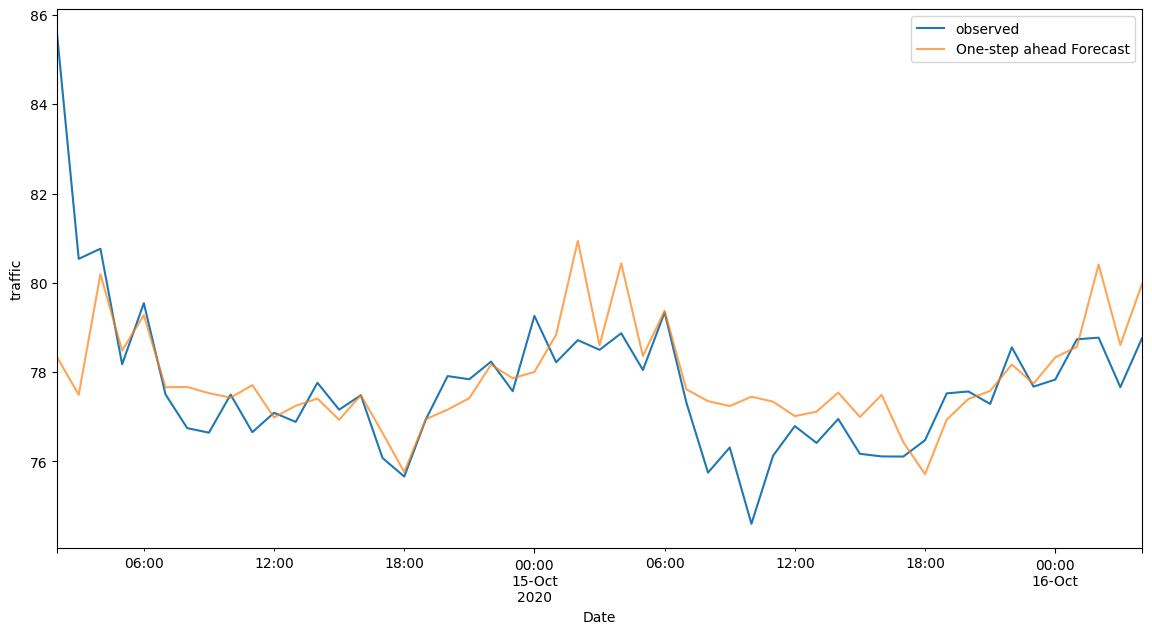

In [155]:
pred = model_fit.get_prediction(start=speed.index[50], end=speed.index[100], dynamic=False)
pred_ci = pred.conf_int()
ax = speed.iloc[50:101].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('traffic')
plt.legend()

In [156]:
mean_squared_error(speed.iloc[50:101], pred.predicted_mean)  # MSE

1.9434986671029237

In [157]:
mean_squared_error(speed.iloc[50:101], pred.predicted_mean, squared=False)           # RMSE

1.3940942102680591

In [158]:
mean_absolute_error(speed.iloc[50:101], pred.predicted_mean) # MAE

0.8142153509568542

Our model with seasonality here is a bit better!